# Collaborative Filtering 

In [1]:
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install --quiet keras

In [35]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import tensorflow as tf

import keras
from keras import layers
from keras import ops

In [3]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6580 - val_loss: 0.6207
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6154 - val_loss: 0.6185
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6089 - val_loss: 0.6151
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6082 - val_loss: 0.6141
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6069 - val_loss: 0.6150
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6072 - val_loss: 0.6130
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6079 - val_loss: 0.6107
Epoch 8/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6064 - val_loss: 0.6131
Epoch 9/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6057 - val_loss: 0.6142
Epoch 10/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6053 - val_loss: 0.6143


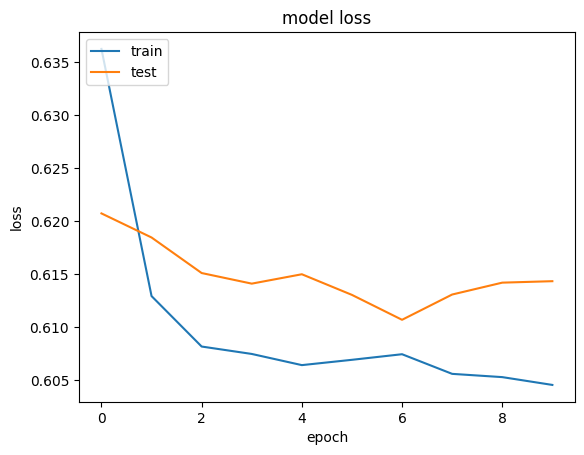

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Nous essayons différentes tailles d'embedding:

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6617 - val_loss: 0.6195
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6135 - val_loss: 0.6117
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6058 - val_loss: 0.6079
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5996 - val_loss: 0.6060
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5979 - val_loss: 0.6051
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5949 - val_loss: 0.6041
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5943 - val_loss: 0.6037
Epoch 8/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5921 - val_loss: 0.6032
Epoch 9/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5920 - val_loss: 0.6029
Epoch 10/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5904 - val_loss: 0.6025
Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6580 - val_loss: 0.6198
Epoch 2/10
1418/1418 ━━━━━━━━━━

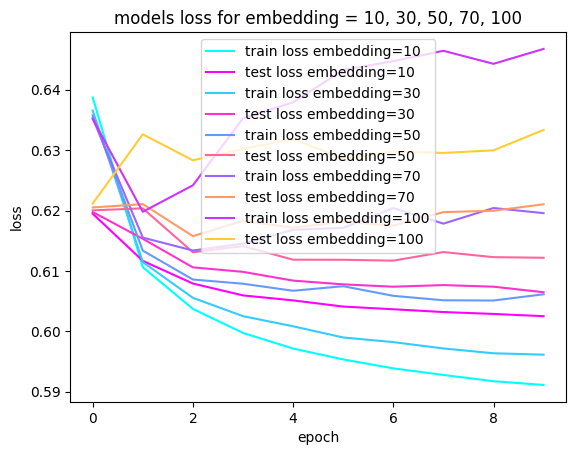

In [30]:
embedding = [10, 30, 50, 70, 100]

plt.figure()

# Création d'un dégradé de couleur
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding)))
colors_2 = plt.cm.plasma(np.linspace(0, 1, len(embedding)))
for i,embd in enumerate(embedding):
    
    model = RecommenderNet(num_users, num_movies, embd)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        )
    history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    )
    plt.plot(history.history["loss"], color = (i/len(embedding),1-i/len(embedding),1), label= f"train loss embedding={embd}")
    plt.plot(history.history["val_loss"], color = (1,i/len(embedding),1-i/len(embedding)), label= f"test loss embedding={embd}")
plt.title("models loss for embedding = 10, 30, 50, 70, 100")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()
    

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6690 - val_loss: 0.6202
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6136 - val_loss: 0.6114
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6044 - val_loss: 0.6074
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5988 - val_loss: 0.6053
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5961 - val_loss: 0.6038
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5942 - val_loss: 0.6030
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5920 - val_loss: 0.6025
Epoch 8/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5909 - val_loss: 0.6021
Epoch 9/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5903 - val_loss: 0.6018
Epoch 10/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5895 - val_loss: 0.6017
Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6684 - val_loss: 0.6203
Epoch 2/10
1418/1418 ━━━━━━━━━━

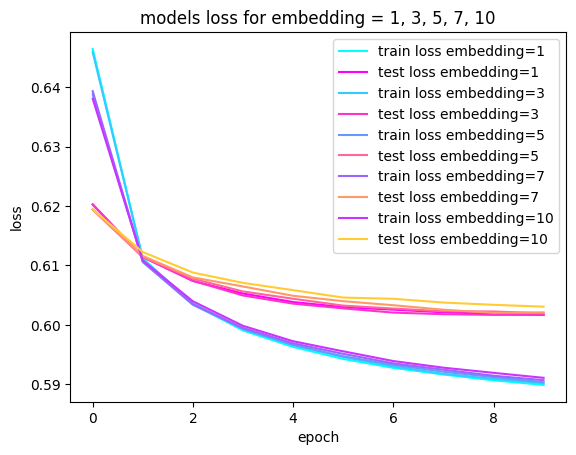

In [31]:
embedding = [1, 3, 5, 7, 10]

plt.figure()

# Création d'un dégradé de couleur
colors = plt.cm.viridis(np.linspace(0, 1, len(embedding)))
colors_2 = plt.cm.plasma(np.linspace(0, 1, len(embedding)))
for i,embd in enumerate(embedding):
    
    model = RecommenderNet(num_users, num_movies, embd)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        )
    history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    )
    plt.plot(history.history["loss"], color = (i/len(embedding),1-i/len(embedding),1), label= f"train loss embedding={embd}")
    plt.plot(history.history["val_loss"], color = (1,i/len(embedding),1-i/len(embedding)), label= f"test loss embedding={embd}")
plt.title("models loss for embedding = 1, 3, 5, 7, 10")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()
    

Nous créons deux modèles avec des embeddings de 10 et 50 pour comparer leurs résultats

In [33]:
# Modele avec un embedding de 50
model_50 = RecommenderNet(num_users, num_movies, 50)
model_50.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)
model_50.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    )

model_10 = RecommenderNet(num_users, num_movies, 10)

model_10.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

# Modele avec un embedding

model_10.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
    )

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6566 - val_loss: 0.6200
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6167 - val_loss: 0.6189
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6101 - val_loss: 0.6139
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6083 - val_loss: 0.6144
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6082 - val_loss: 0.6140
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6082 - val_loss: 0.6137
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6066 - val_loss: 0.6134
Epoch 8/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6049 - val_loss: 0.6166
Epoch 9/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6053 - val_loss: 0.6142
Epoch 10/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6060 - val_loss: 0.6176
Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6616 - val_loss: 0.6197
Epoch 2/10
1418/1418 ━━━━━━━━━━

In [34]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = 600
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings_50 = model_50.predict(user_movie_array).flatten()
ratings_10 =  model_10.predict(user_movie_array).flatten()

top_ratings_indices_50 = ratings_50.argsort()[-10:][::-1]
top_ratings_indices_10 = ratings_50.argsort()[-10:][::-1]

recommended_movie_ids_50 = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices_50
]

recommended_movie_ids_10 = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices_10
]


print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations modele embedding=50")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids_50)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations modele embedding=10")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids_10)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing recommendations for user: 600
Movies with high ratings from user
--------------------------------
Heathers (1989) : Comedy
Nashville (1975) : Drama|Musical
Fisher King, The (1991) : Comedy|Drama|Fantasy|Romance
Adventures of Baron Munchausen, The (1988) : Adventure|Comedy|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
--------------------------------
Top 10 movie recommendations modele embedding=50
--------------------------------
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Streetcar Named Desire, A (1951) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Godfather: Part II, The (1974) : Crime|Drama
Patton (1970) : Drama|War
Cool Hand Luke (1967) : Drama
High Noon (1952) : Drama|Western
For a Few Dollars More (Per qualche dollaro in più) (1965) : Action|Drama|Thriller|Western
Road Warrior, The (Mad Max 2) (198